In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
sns.set()

In [2]:
tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
etf = yf.Tickers(tickers)
data = etf.history(start='2010-01-01', actions=False)
data.drop(['Open', 'High', 'Low', 'Volume'], inplace=True, axis=1)
data = data.droplevel(0, axis=1).resample('W').last()

[*********************100%***********************]  9 of 9 completed


In [3]:
rets = data.pct_change().fillna(0)

In [4]:
pal = sns.color_palette('Spectral', len(tickers))

## Equal Weight PF

<Axes: xlabel='Date'>

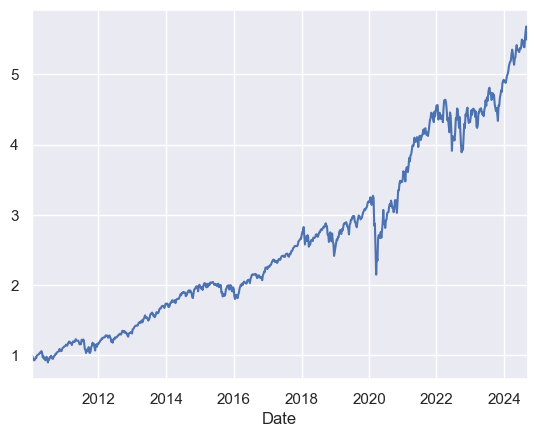

In [5]:
port_rets = rets.mean(axis=1)
(1 + port_rets).cumprod().plot()

## Volatility Targeting


<Axes: xlabel='Date'>

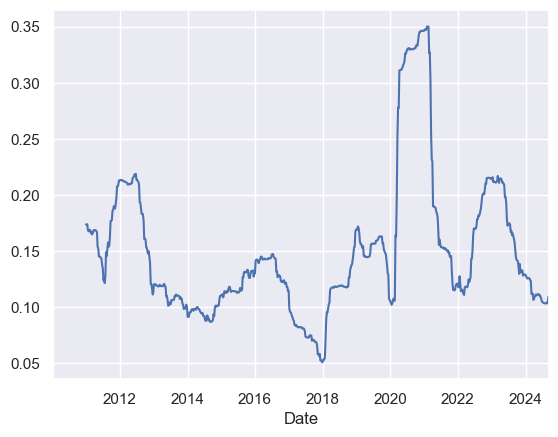

In [6]:
# 1 year rolling Vol
rolling_vol = port_rets.rolling(52).std() * np.sqrt(52)
rolling_vol.plot()

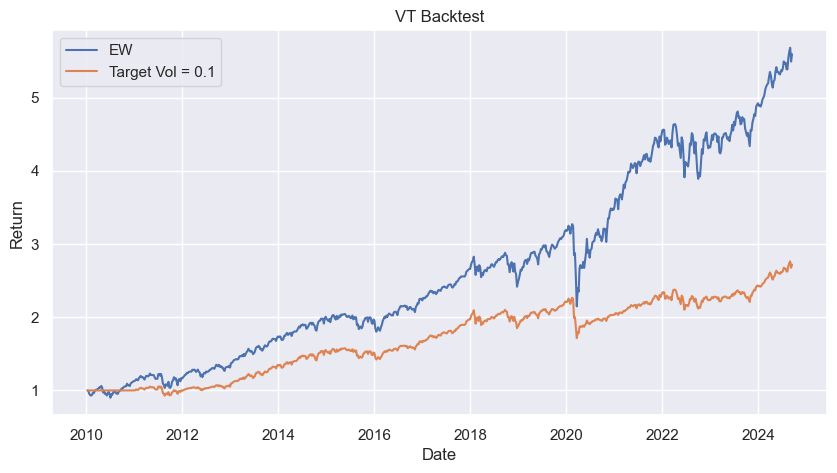

In [7]:
# target vol = 10%
target_vol = 0.1
vt_weights = (target_vol/rolling_vol).fillna(0)

# no leverage
vt_weights[vt_weights>1] =1 # if vt is more than 1, just got with 1

tvol_rets = (port_rets*vt_weights.shift()).fillna(0) # shift : forward bias
tvol_cum_rets = (1+tvol_rets).cumprod()
    
plt.figure(figsize=(10, 5))
plt.plot((1 + port_rets).cumprod(), label='EW')
plt.plot(tvol_cum_rets, label=f'Target Vol = {target_vol}')
plt.title('VT Backtest')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()

In [13]:
vt_weights

Date
2010-01-10 00:00:00+00:00    0.000000
2010-01-17 00:00:00+00:00    0.000000
2010-01-24 00:00:00+00:00    0.000000
2010-01-31 00:00:00+00:00    0.000000
2010-02-07 00:00:00+00:00    0.000000
                               ...   
2024-08-18 00:00:00+00:00    0.963866
2024-08-25 00:00:00+00:00    0.957596
2024-09-01 00:00:00+00:00    0.966910
2024-09-08 00:00:00+00:00    0.917089
2024-09-15 00:00:00+00:00    0.908745
Freq: W-SUN, Length: 767, dtype: float64

In [12]:
tvol_rets

Date
2010-01-10 00:00:00+00:00    0.000000
2010-01-17 00:00:00+00:00   -0.000000
2010-01-24 00:00:00+00:00   -0.000000
2010-01-31 00:00:00+00:00   -0.000000
2010-02-07 00:00:00+00:00   -0.000000
                               ...   
2024-08-18 00:00:00+00:00    0.028300
2024-08-25 00:00:00+00:00    0.015020
2024-09-01 00:00:00+00:00    0.008904
2024-09-08 00:00:00+00:00   -0.032006
2024-09-15 00:00:00+00:00    0.016492
Freq: W-SUN, Length: 767, dtype: float64

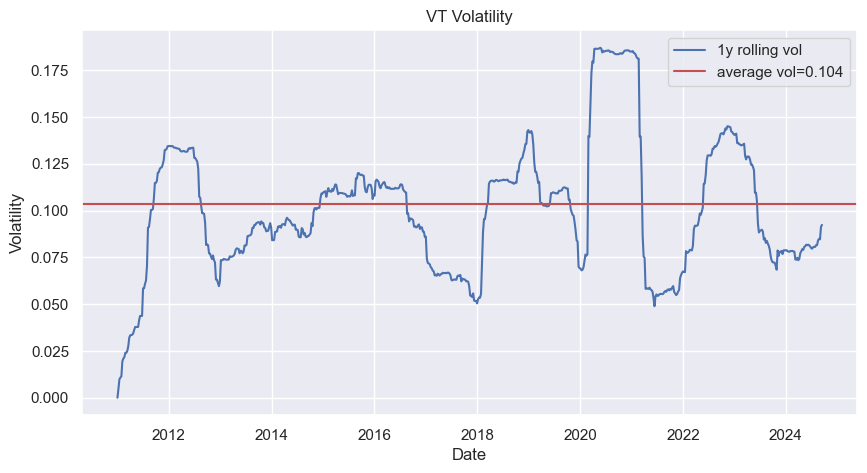

In [8]:
plt.figure(figsize=(10, 5))
plt.plot((tvol_rets.rolling(52).std() * np.sqrt(52)).dropna(), label='1y rolling vol')
plt.axhline((tvol_rets.std() * np.sqrt(52)).mean(), color='r', label=f'average vol={np.round((tvol_rets.std() * np.sqrt(52)).mean(), 3)}')
plt.title('VT Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [9]:
# cash
1 - vt_weights

Date
2010-01-10 00:00:00+00:00    1.000000
2010-01-17 00:00:00+00:00    1.000000
2010-01-24 00:00:00+00:00    1.000000
2010-01-31 00:00:00+00:00    1.000000
2010-02-07 00:00:00+00:00    1.000000
                               ...   
2024-08-18 00:00:00+00:00    0.036134
2024-08-25 00:00:00+00:00    0.042404
2024-09-01 00:00:00+00:00    0.033090
2024-09-08 00:00:00+00:00    0.082911
2024-09-15 00:00:00+00:00    0.091255
Freq: W-SUN, Length: 767, dtype: float64

In [10]:
vt_weights_df = pd.concat([vt_weights, 1-vt_weights], axis=1, join='inner')
vt_weights_df.columns = ['portfolio', 'cash']
vt_weights_df

,portfolio,cash
Date,,
2010-01-10 00:00:00+00:00,0.000000,1.000000
2010-01-17 00:00:00+00:00,0.000000,1.000000
2010-01-24 00:00:00+00:00,0.000000,1.000000
2010-01-31 00:00:00+00:00,0.000000,1.000000
2010-02-07 00:00:00+00:00,0.000000,1.000000
...,...,...
2024-08-18 00:00:00+00:00,0.963866,0.036134
2024-08-25 00:00:00+00:00,0.957596,0.042404
2024-09-01 00:00:00+00:00,0.966910,0.033090


Text(0, 0.5, 'Weights')

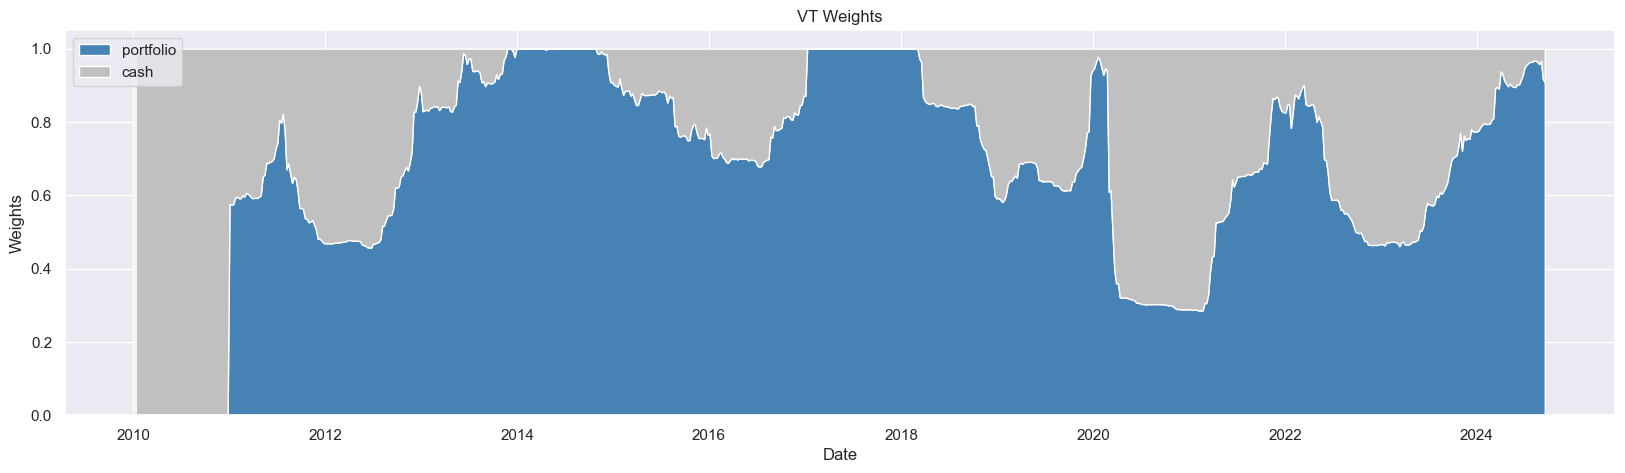

In [11]:
plt.figure(figsize=(20, 5))
plt.stackplot(vt_weights_df.index, vt_weights_df.T, labels=vt_weights_df.columns, colors=['steelblue', 'silver'])
plt.legend(loc='upper left')
plt.title('VT Weights')
plt.xlabel('Date')
plt.ylabel('Weights')